In [16]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

In [17]:
engine = create_engine("postgresql+psycopg2://voprosovnety@localhost:5432/superstore_db")
with engine.connect() as conn:
    print(conn.execute(text("select 1")).scalar())

1


In [18]:
query = """
select
    f.row_id,
    f.order_id,
    f.order_date,
    f.ship_date,
    c.segment,
    p.category,
    p.sub_category,
    p.product_name,
    g.region,
    g.state,
    g.city,
    f.sales,
    f.profit,
    f.discount,
    f.quantity
from
    fact_sales f
    join dim_customer c on f.customer_id = c.customer_id
    join dim_product p on f.product_key = p.product_key
    join dim_geo g on f.geo_id = g.geo_id
"""

df = pd.read_sql(query, engine)

In [19]:
df["order_date"] = pd.to_datetime(df["order_date"])
df["month"] = df["order_date"].dt.to_period("M")

In [20]:
monthly_metrics = (
    df
    .groupby("month")
    .agg(
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum")
    )
    .reset_index()
    .sort_values("month")
)

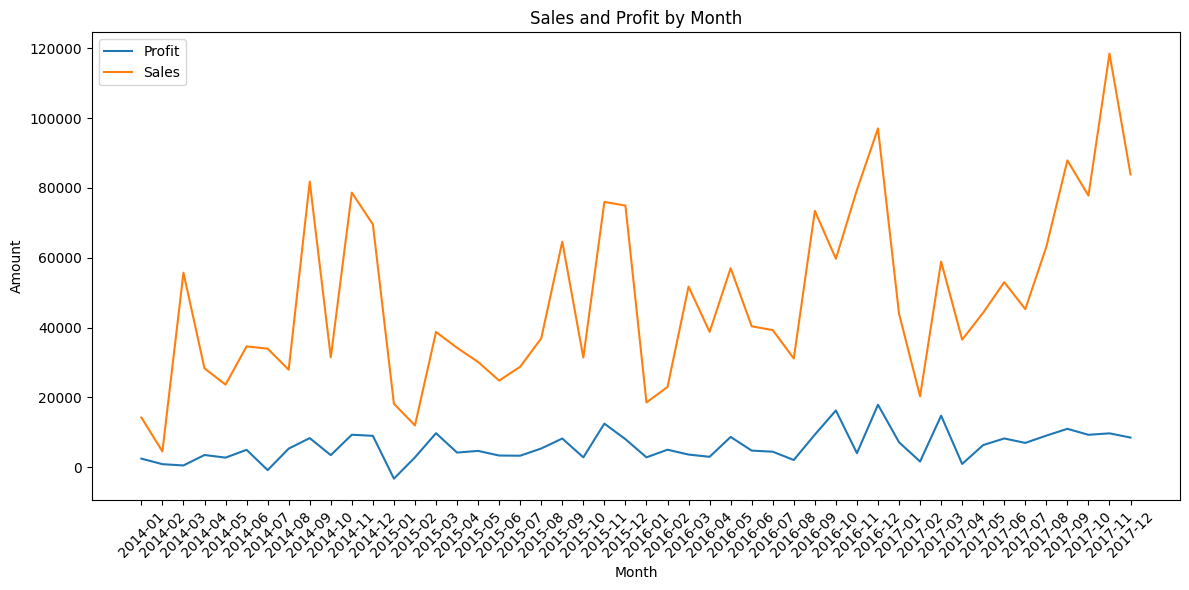

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_metrics["month"].astype(str), monthly_metrics["total_profit"], label="Profit")
plt.plot(monthly_metrics["month"].astype(str), monthly_metrics["total_sales"], label="Sales")
plt.title("Sales and Profit by Month")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 📈 Monthly Sales and Profit Trend

- Total sales show an overall upward trend over time, indicating business growth.
- Profit remains volatile and does not grow proportionally with sales.
- This suggests that increased revenue is partially offset by higher discounts or costs.

In [22]:
segment_metrics = (
    df
    .groupby("segment")
    .agg(
        orders=("order_id", "nunique"),
        rows=("row_id", "size"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
        avg_discount=("discount", lambda x: x.mean().round(3))
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3),
        avg_order_value=lambda x: (x.total_sales / x.orders).round(2)
    )
    .reset_index()
    .sort_values("total_profit", ascending=False)
)

segment_metrics

,segment,orders,rows,total_sales,total_profit,avg_discount,profit_margin,avg_order_value
0,Consumer,2586,5191,1161401.34,134119.33,0.158,0.115,449.11
1,Corporate,1514,3020,706146.44,91979.45,0.158,0.130,466.41
2,Home Office,909,1783,429653.29,60299.01,0.147,0.140,472.67


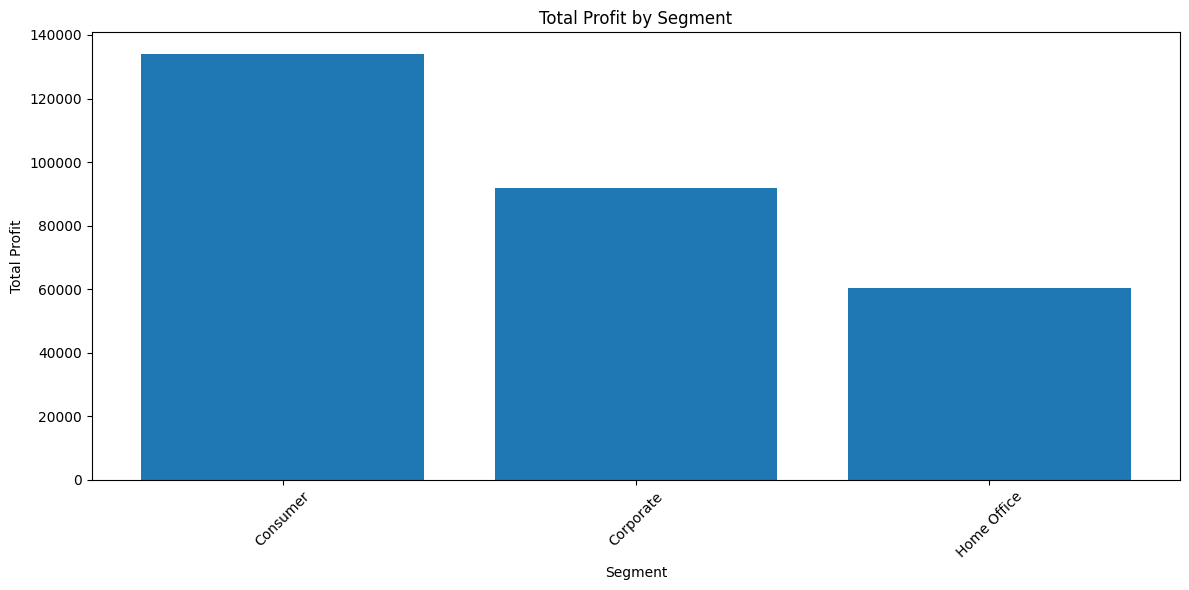

In [23]:
plt.figure(figsize=(12, 6))
plt.bar(segment_metrics["segment"], segment_metrics["total_profit"])
plt.title("Total Profit by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

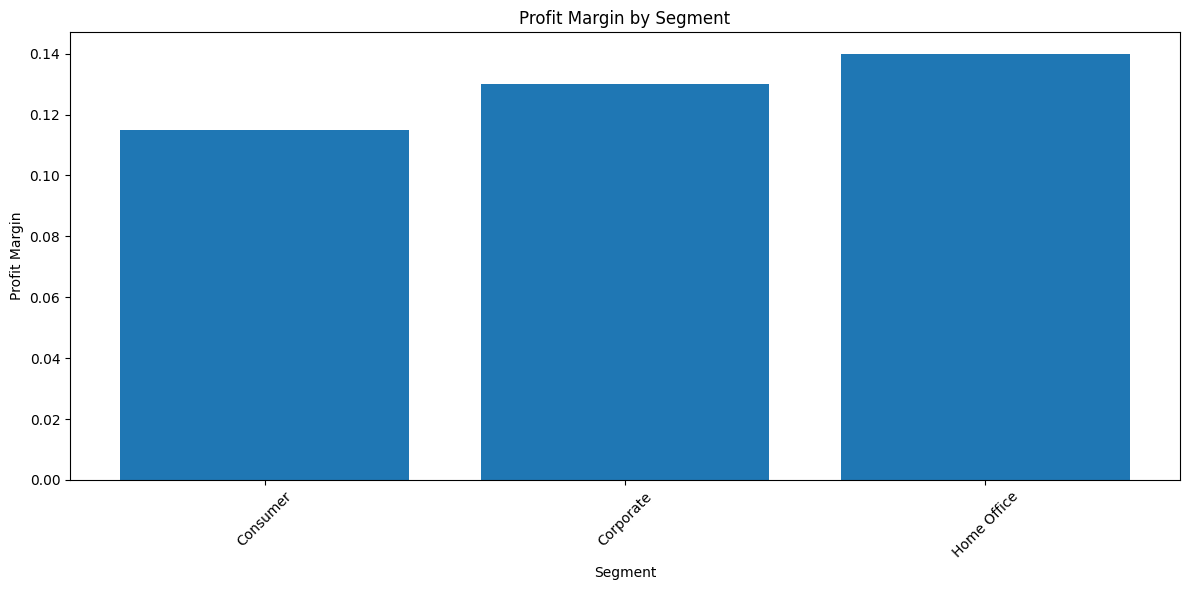

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(segment_metrics["segment"], segment_metrics["profit_margin"])
plt.title("Profit Margin by Segment")
plt.xlabel("Segment")
plt.ylabel("Profit Margin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 👥 Customer Segment Analysis

- The **Consumer** segment generates the highest total profit due to its large sales volume.
- **Home Office** shows the highest profit margin, indicating higher efficiency but lower scale.
- **Corporate** segment performs moderately across both profit and margin.
- This highlights a clear trade-off between revenue scale and profitability efficiency.

In [25]:
category_metrics = (
    df
    .groupby(["category", "sub_category"])
    .agg(
        orders=("order_id", "nunique"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
        avg_discount=("discount", lambda x: x.mean().round(3))
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3)
    )
    .reset_index()
    .sort_values("total_profit", ascending=False)
)

top_subcategories = category_metrics.head()
bottom_subcategories = category_metrics.sort_values("total_profit", ascending=True).head()

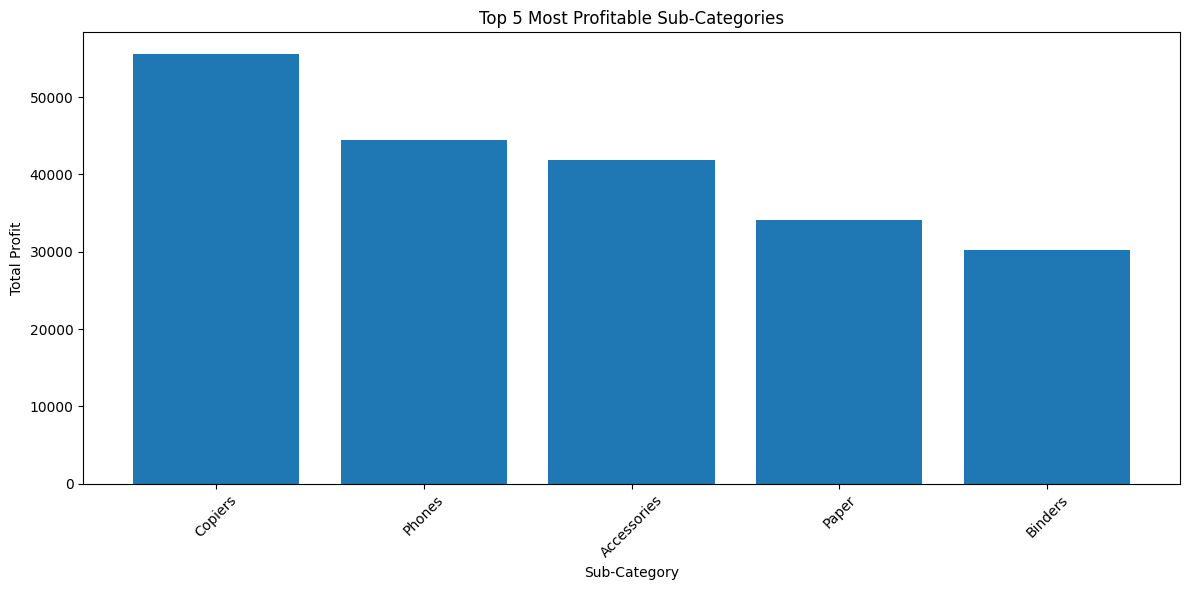

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(top_subcategories["sub_category"], top_subcategories["total_profit"])
plt.title("Top 5 Most Profitable Sub-Categories")
plt.xlabel("Sub-Category")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

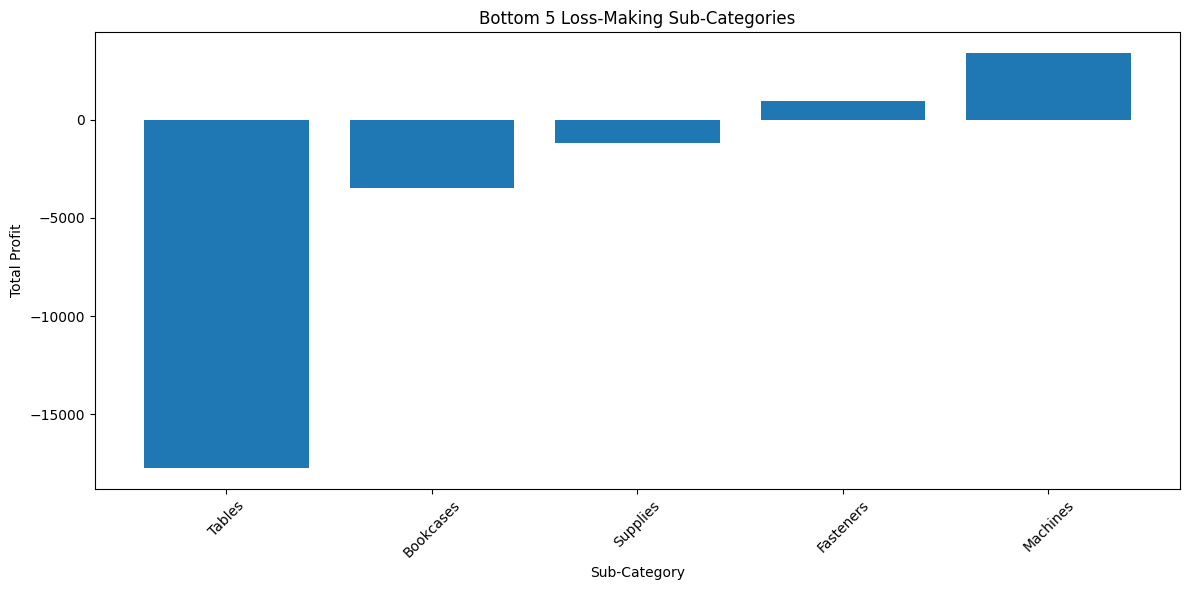

In [27]:
plt.figure(figsize=(12, 6))
plt.bar(bottom_subcategories["sub_category"], bottom_subcategories["total_profit"])
plt.title("Bottom 5 Loss-Making Sub-Categories")
plt.xlabel("Sub-Category")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🗂️ Category & Sub-Category Insights

- **Copiers, Phones, Accessories, Paper, and Binders** are the top profit-generating sub-categories, forming the core profit base of the business.
- **Tables** stand out as a major loss-making sub-category, with losses significantly exceeding all others.
- Other low-performing sub-categories show relatively small losses or near break-even results.
- Business losses are highly concentrated in a single sub-category rather than spread across the product portfolio.

### 💡 Business Recommendations

- Review pricing, discount strategy, and cost structure for **Tables** to identify the root cause of losses.
- Focus growth and marketing efforts on high-profit sub-categories to maximize overall profitability.
- Monitor low-margin categories, but prioritize corrective actions on the most loss-driving products.

In [28]:
discount_metrics = (
    df
    .groupby(["discount"])
    .agg(
        rows=("row_id", "size"),
        total_sales=("sales", "sum"),
        total_profit=("profit", "sum"),
    )
    .assign(
        profit_margin=lambda x: (x.total_profit / x.total_sales).round(3),
    )
    .reset_index()
    .sort_values("discount")
)

discount_metrics

,discount,rows,total_sales,total_profit,profit_margin
0,0.00,4798,1087908.47,320987.88,0.295
1,0.10,94,54369.30,9029.21,0.166
2,0.15,52,27558.59,1418.98,0.051
3,0.20,3657,764594.28,90338.16,0.118
4,0.30,227,103226.76,-10369.34,-0.100
5,0.32,27,14493.45,-2391.16,-0.165
6,0.40,206,116417.83,-23057.08,-0.198
7,0.45,11,5484.98,-2493.12,-0.455
8,0.50,66,58918.65,-20506.51,-0.348
9,0.60,138,6644.68,-5944.64,-0.895


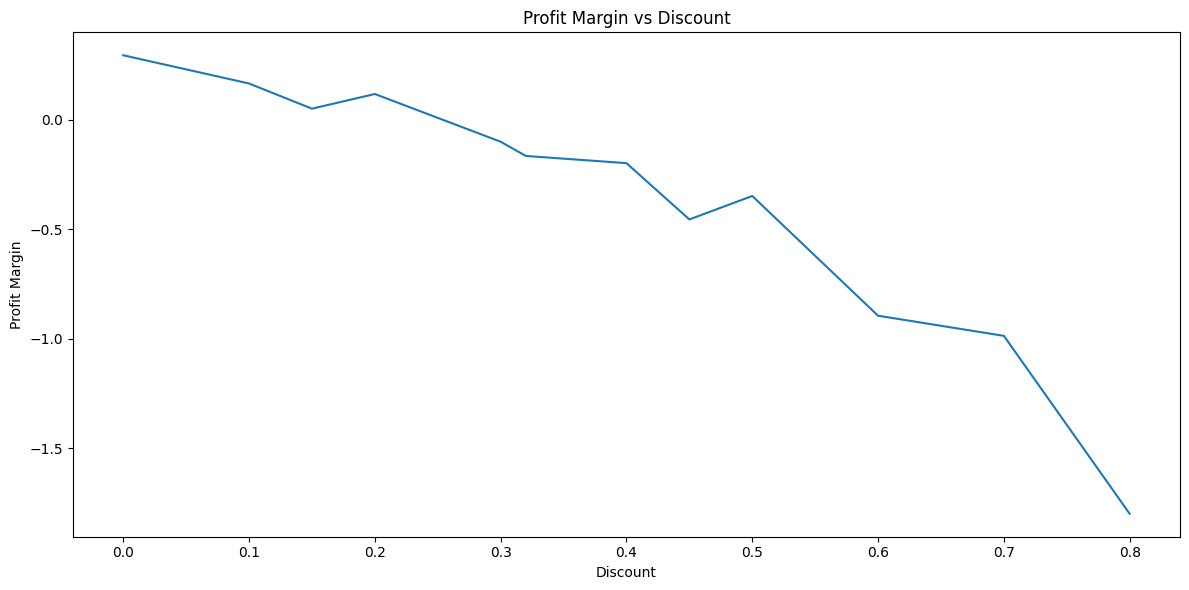

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(discount_metrics["discount"], discount_metrics["profit_margin"])
plt.title("Profit Margin vs Discount")
plt.xlabel("Discount")
plt.ylabel("Profit Margin")
plt.tight_layout()
plt.show()

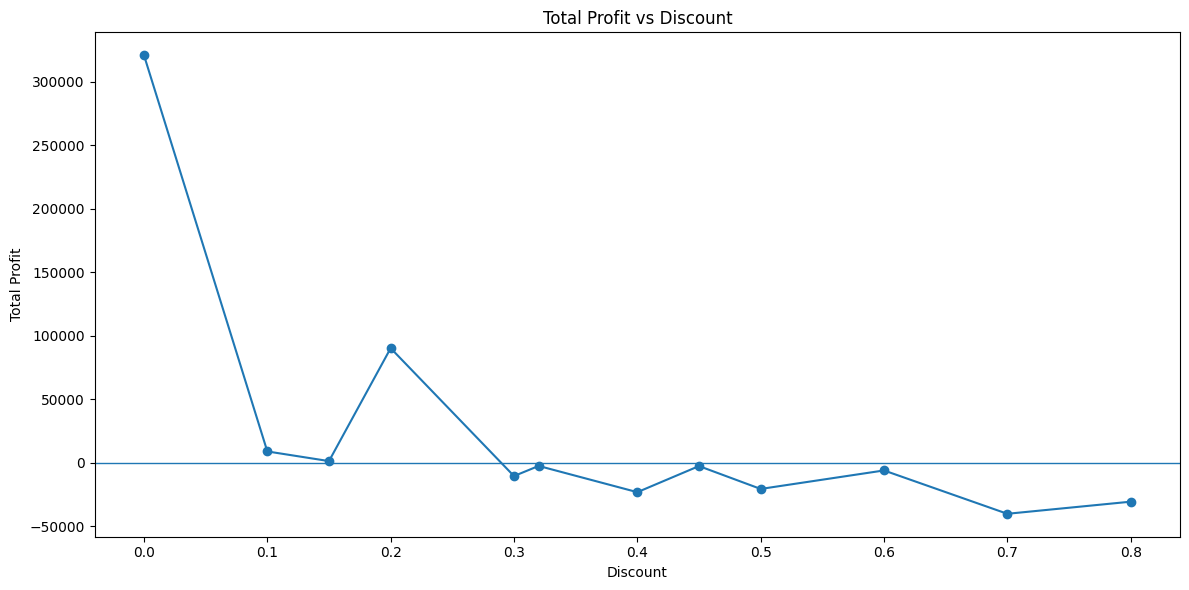

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(discount_metrics["discount"], discount_metrics["total_profit"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("Total Profit vs Discount")
plt.xlabel("Discount")
plt.ylabel("Total Profit")
plt.tight_layout()
plt.show()